In [1]:
# !pip install mss pydirectinput pytesseract

In [2]:
# !pip install protobuf==3.20.*

In [3]:
# !pip install tesseract

In [4]:
# !pip install tesseract-ocr

In [5]:
import pydirectinput 
import cv2 
import numpy as np 
import pytesseract 
import time 
import os 

from stable_baselines3.common.callbacks import BaseCallback 
from stable_baselines3.common import env_checker
from stable_baselines3 import DQN 
from stable_baselines3.common.monitor import Monitor 
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from mss import mss 
from matplotlib import pyplot as plt 
from gym import Env 
from gym.spaces import Box, Discrete

In [6]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [7]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1, 83, 100), dtype=np.uint8)
        self.action_space = Discrete(3)
        self.cap = mss() 
        self.game_location = {'top': 300, 'left': 0, 'width': 1000, 'height': 600}
        self.done_location = {'top': 420, 'left': 630, 'width': 660, 'height': 80}
        
    def step(self, action):
        action_map = {
            0: 'space',
            1: 'down', 
            2: 'no_op'
        }
        
        if action != 2:
            pydirectinput.press(action_map[action])
        
        done, done_cap = self.get_done() 
        observation = self.get_observation() 
        reward = 1 
        info = {} 
        return observation, reward, done, info 
    
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation() 
    
    def render(self):
        cv2.imshow('Game', self.current_time)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close() 
            
    def close(self):
        cv2.destroyAllWindows() 
        
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 83))
        channel = np.reshape(resized, (1, 83, 100))
        return channel 
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_string = ['GAME', 'GAHE']
        done = False 
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_string:
            done = True
        return done, done_cap

In [8]:
env = WebGame()

In [9]:
obs = env.get_observation() 

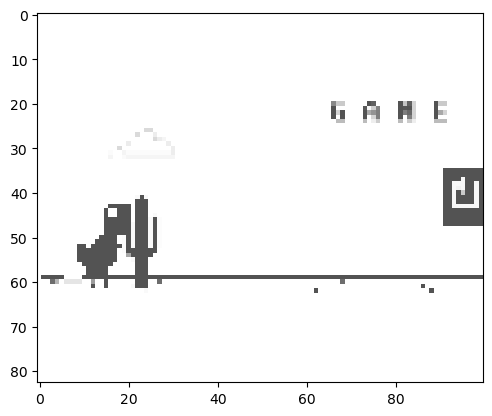

In [10]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))
plt.show()

In [11]:
done, done_cap = env.get_done()

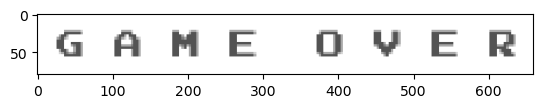

In [12]:
plt.imshow(done_cap)
plt.show()

In [13]:
pytesseract.image_to_string(done_cap)[:4]

'GAME'

In [14]:
done 

True

In [15]:
for episode in range(10):
    obs = env.reset() 
    done = False 
    total_reward = 0 
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward 
    print('Total reward for episode {} is {}'.format(episode + 1, total_reward)) 
env.close()

Total reward for episode 1 is 19
Total reward for episode 2 is 12
Total reward for episode 3 is 9
Total reward for episode 4 is 10
Total reward for episode 5 is 12
Total reward for episode 6 is 14
Total reward for episode 7 is 10
Total reward for episode 8 is 9
Total reward for episode 9 is 10
Total reward for episode 10 is 11


In [16]:
env_checker.check_env(env)

In [17]:
class TrainingAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainingAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq 
        self.save_path = save_path 
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [18]:
CHECKPOINT_DIR = '../Tutorial/Models/Dino/train/'
LOG_DIR = '../Tutorial/Models/Dino/logs/'

In [19]:
callback = TrainingAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [20]:
env = WebGame()

In [21]:
model = DQN('CnnPolicy', env, verbose=1, buffer_size=12000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [22]:
model.learn(total_timesteps=100000)

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.8     |
|    ep_rew_mean      | 12.8     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 29       |
|    total_timesteps  | 51       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 55       |
|    total_timesteps  | 90       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.5     |
|    ep_rew_mean      | 11.5     |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.902    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 1        |
|    time_elapsed     | 612      |
|    total_timesteps  | 1031     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.186    |
|    n_updates        | 7        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.1     |
|    ep_rew_mean      | 11.1     |
|    exploration_rate | 0.898    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 1        |
|    time_elapsed     | 639      |
|    total_timesteps  | 1070     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0516   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.1     |
|    ep_rew_mean      | 11.1     |
|    exploration_rate | 0.833    |
| time/               |          |
|    episodes         | 156      |
|    fps              | 1        |
|    time_elapsed     | 1039     |
|    total_timesteps  | 1753     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15e-05 |
|    n_updates        | 188      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.1     |
|    ep_rew_mean      | 11.1     |
|    exploration_rate | 0.83     |
| time/               |          |
|    episodes         | 160      |
|    fps              | 1        |
|    time_elapsed     | 1064     |
|    total_timesteps  | 1792     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.31e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.8     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.769    |
| time/               |          |
|    episodes         | 220      |
|    fps              | 1        |
|    time_elapsed     | 1459     |
|    total_timesteps  | 2427     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26e-05 |
|    n_updates        | 356      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.9     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.765    |
| time/               |          |
|    episodes         | 224      |
|    fps              | 1        |
|    time_elapsed     | 1487     |
|    total_timesteps  | 2471     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.49e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.8     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.703    |
| time/               |          |
|    episodes         | 284      |
|    fps              | 1        |
|    time_elapsed     | 1887     |
|    total_timesteps  | 3126     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.53e-07 |
|    n_updates        | 531      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.8     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.699    |
| time/               |          |
|    episodes         | 288      |
|    fps              | 1        |
|    time_elapsed     | 1913     |
|    total_timesteps  | 3167     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.2     |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.635    |
| time/               |          |
|    episodes         | 348      |
|    fps              | 1        |
|    time_elapsed     | 2324     |
|    total_timesteps  | 3847     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.89e-07 |
|    n_updates        | 711      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.1     |
|    ep_rew_mean      | 11.1     |
|    exploration_rate | 0.631    |
| time/               |          |
|    episodes         | 352      |
|    fps              | 1        |
|    time_elapsed     | 2351     |
|    total_timesteps  | 3887     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.99e-07 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.8     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.569    |
| time/               |          |
|    episodes         | 412      |
|    fps              | 1        |
|    time_elapsed     | 2755     |
|    total_timesteps  | 4536     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.38e-07 |
|    n_updates        | 883      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.9     |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.565    |
| time/               |          |
|    episodes         | 416      |
|    fps              | 1        |
|    time_elapsed     | 2782     |
|    total_timesteps  | 4577     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.62e-07 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.6     |
|    ep_rew_mean      | 10.6     |
|    exploration_rate | 0.504    |
| time/               |          |
|    episodes         | 476      |
|    fps              | 1        |
|    time_elapsed     | 3185     |
|    total_timesteps  | 5217     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.9e-07  |
|    n_updates        | 1054     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.7     |
|    ep_rew_mean      | 10.7     |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 480      |
|    fps              | 1        |
|    time_elapsed     | 3211     |
|    total_timesteps  | 5260     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.8     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.439    |
| time/               |          |
|    episodes         | 540      |
|    fps              | 1        |
|    time_elapsed     | 3611     |
|    total_timesteps  | 5901     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.01e-07 |
|    n_updates        | 1225     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.8     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.435    |
| time/               |          |
|    episodes         | 544      |
|    fps              | 1        |
|    time_elapsed     | 3639     |
|    total_timesteps  | 5946     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.69e-07 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.4     |
|    ep_rew_mean      | 10.4     |
|    exploration_rate | 0.376    |
| time/               |          |
|    episodes         | 604      |
|    fps              | 1        |
|    time_elapsed     | 4038     |
|    total_timesteps  | 6564     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.05e-07 |
|    n_updates        | 1390     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.4     |
|    ep_rew_mean      | 10.4     |
|    exploration_rate | 0.372    |
| time/               |          |
|    episodes         | 608      |
|    fps              | 1        |
|    time_elapsed     | 4065     |
|    total_timesteps  | 6608     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.74e-07 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.3     |
|    ep_rew_mean      | 10.3     |
|    exploration_rate | 0.314    |
| time/               |          |
|    episodes         | 668      |
|    fps              | 1        |
|    time_elapsed     | 4463     |
|    total_timesteps  | 7218     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.18e-07 |
|    n_updates        | 1554     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.3     |
|    ep_rew_mean      | 10.3     |
|    exploration_rate | 0.31     |
| time/               |          |
|    episodes         | 672      |
|    fps              | 1        |
|    time_elapsed     | 4490     |
|    total_timesteps  | 7262     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.65e-07 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.6     |
|    ep_rew_mean      | 10.6     |
|    exploration_rate | 0.248    |
| time/               |          |
|    episodes         | 732      |
|    fps              | 1        |
|    time_elapsed     | 4893     |
|    total_timesteps  | 7921     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05e-06 |
|    n_updates        | 1730     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.7     |
|    ep_rew_mean      | 10.7     |
|    exploration_rate | 0.243    |
| time/               |          |
|    episodes         | 736      |
|    fps              | 1        |
|    time_elapsed     | 4922     |
|    total_timesteps  | 7970     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.67e-07 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.6     |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.174    |
| time/               |          |
|    episodes         | 796      |
|    fps              | 1        |
|    time_elapsed     | 5319     |
|    total_timesteps  | 8691     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.97e-06 |
|    n_updates        | 1922     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.8     |
|    ep_rew_mean      | 11.8     |
|    exploration_rate | 0.169    |
| time/               |          |
|    episodes         | 800      |
|    fps              | 1        |
|    time_elapsed     | 5348     |
|    total_timesteps  | 8747     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.47e-07 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.6     |
|    ep_rew_mean      | 12.6     |
|    exploration_rate | 0.0974   |
| time/               |          |
|    episodes         | 860      |
|    fps              | 1        |
|    time_elapsed     | 5737     |
|    total_timesteps  | 9501     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.57e-07 |
|    n_updates        | 2125     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.7     |
|    ep_rew_mean      | 12.7     |
|    exploration_rate | 0.0925   |
| time/               |          |
|    episodes         | 864      |
|    fps              | 1        |
|    time_elapsed     | 5765     |
|    total_timesteps  | 9553     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.94e-07 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.7     |
|    ep_rew_mean      | 12.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 924      |
|    fps              | 1        |
|    time_elapsed     | 6173     |
|    total_timesteps  | 10319    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0326   |
|    n_updates        | 2329     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.6     |
|    ep_rew_mean      | 12.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 928      |
|    fps              | 1        |
|    time_elapsed     | 6198     |
|    total_timesteps  | 10362    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0309   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.1     |
|    ep_rew_mean      | 14.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 988      |
|    fps              | 1        |
|    time_elapsed     | 6603     |
|    total_timesteps  | 11257    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00913  |
|    n_updates        | 2564     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.2     |
|    ep_rew_mean      | 14.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 992      |
|    fps              | 1        |
|    time_elapsed     | 6628     |
|    total_timesteps  | 11308    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0055   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.7     |
|    ep_rew_mean      | 13.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1052     |
|    fps              | 1        |
|    time_elapsed     | 7011     |
|    total_timesteps  | 12097    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00282  |
|    n_updates        | 2774     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.7     |
|    ep_rew_mean      | 13.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1056     |
|    fps              | 1        |
|    time_elapsed     | 7036     |
|    total_timesteps  | 12143    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00352  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.3     |
|    ep_rew_mean      | 13.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1116     |
|    fps              | 1        |
|    time_elapsed     | 7419     |
|    total_timesteps  | 12936    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0156   |
|    n_updates        | 2983     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.2     |
|    ep_rew_mean      | 13.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1120     |
|    fps              | 1        |
|    time_elapsed     | 7445     |
|    total_timesteps  | 12982    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00104  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 13       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1180     |
|    fps              | 1        |
|    time_elapsed     | 7827     |
|    total_timesteps  | 13765    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00221  |
|    n_updates        | 3191     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 13       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1184     |
|    fps              | 1        |
|    time_elapsed     | 7853     |
|    total_timesteps  | 13810    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00246  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.3     |
|    ep_rew_mean      | 13.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1244     |
|    fps              | 1        |
|    time_elapsed     | 8239     |
|    total_timesteps  | 14615    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00388  |
|    n_updates        | 3403     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.1     |
|    ep_rew_mean      | 13.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1248     |
|    fps              | 1        |
|    time_elapsed     | 8265     |
|    total_timesteps  | 14667    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00341  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.4     |
|    ep_rew_mean      | 13.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1308     |
|    fps              | 1        |
|    time_elapsed     | 8648     |
|    total_timesteps  | 15482    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00282  |
|    n_updates        | 3620     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.6     |
|    ep_rew_mean      | 13.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1312     |
|    fps              | 1        |
|    time_elapsed     | 8674     |
|    total_timesteps  | 15540    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000193 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.5     |
|    ep_rew_mean      | 13.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1372     |
|    fps              | 1        |
|    time_elapsed     | 9054     |
|    total_timesteps  | 16332    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00107  |
|    n_updates        | 3832     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.4     |
|    ep_rew_mean      | 13.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1376     |
|    fps              | 1        |
|    time_elapsed     | 9080     |
|    total_timesteps  | 16375    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0128   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.1     |
|    ep_rew_mean      | 13.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1436     |
|    fps              | 1        |
|    time_elapsed     | 9464     |
|    total_timesteps  | 17181    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00302  |
|    n_updates        | 4045     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.1     |
|    ep_rew_mean      | 13.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1440     |
|    fps              | 1        |
|    time_elapsed     | 9490     |
|    total_timesteps  | 17228    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00118  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.4     |
|    ep_rew_mean      | 13.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1500     |
|    fps              | 1        |
|    time_elapsed     | 9873     |
|    total_timesteps  | 18034    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.02     |
|    n_updates        | 4258     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.4     |
|    ep_rew_mean      | 13.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1504     |
|    fps              | 1        |
|    time_elapsed     | 9899     |
|    total_timesteps  | 18092    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000285 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.3     |
|    ep_rew_mean      | 13.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1564     |
|    fps              | 1        |
|    time_elapsed     | 10284    |
|    total_timesteps  | 18899    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000308 |
|    n_updates        | 4474     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.2     |
|    ep_rew_mean      | 13.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1568     |
|    fps              | 1        |
|    time_elapsed     | 10309    |
|    total_timesteps  | 18947    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00183  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 13       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1628     |
|    fps              | 1        |
|    time_elapsed     | 10698    |
|    total_timesteps  | 19721    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00749  |
|    n_updates        | 4680     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.1     |
|    ep_rew_mean      | 13.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1632     |
|    fps              | 1        |
|    time_elapsed     | 10725    |
|    total_timesteps  | 19794    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00214  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.6     |
|    ep_rew_mean      | 18.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1692     |
|    fps              | 1        |
|    time_elapsed     | 11313    |
|    total_timesteps  | 21132    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0233   |
|    n_updates        | 5032     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.1     |
|    ep_rew_mean      | 19.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1696     |
|    fps              | 1        |
|    time_elapsed     | 11359    |
|    total_timesteps  | 21236    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00635  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.3     |
|    ep_rew_mean      | 27.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1756     |
|    fps              | 1        |
|    time_elapsed     | 12065    |
|    total_timesteps  | 22921    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00751  |
|    n_updates        | 5480     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.4     |
|    ep_rew_mean      | 27.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1760     |
|    fps              | 1        |
|    time_elapsed     | 12113    |
|    total_timesteps  | 23037    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00336  |
|    n_updates      

KeyboardInterrupt: 

In [ ]:
model.save('Dino_model')

In [ ]:
for episode in range(5):
    obs = env.reset() 
    done = False 
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward 
    print('Total reward for episode {} is {}'.format(episode + 1, total_reward))
    time.sleep(2)
env.close()